<a href="https://colab.research.google.com/github/succSeeded/dl-2025/blob/main/hws/week04_finetuning/seminar_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 04 seminar: Finetuning.

In [1]:
import os
import time
import requests
from tqdm.auto import trange, tqdm
from copy import deepcopy
from collections import defaultdict

import numpy as np
import pandas as pd

# charts and display libs
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML

# pytorch
import torch
import torchvision
from torchvision import transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure that output below says `device=device(type='cuda')` - you will need CUDA for faster model runs
# If in Colab, we recommend that you go to Runtime -> Change Runtime Type -> GPU

print(f"{torch.__version__=}, {torchvision.__version__=}, {device=}, {torch.get_num_threads()=}")

torch.__version__='2.7.1+cu126', torchvision.__version__='0.22.1+cu126', device=device(type='cuda'), torch.get_num_threads()=8


## TorchVision

[Torchvision](https://pytorch.org/vision/main/index.html) - part of PyTorch library with convenient tools and data for deep learning in visual domain.
- contains a number of popular vision [datasets](https://pytorch.org/vision/stable/datasets.html)
- preprocessing [tools](https://pytorch.org/vision/stable/transforms.html)
- and most importantly, [pre-trained models](https://pytorch.org/vision/main/models.html).

# Datasets: Imagenet

![imagenet_tiles](https://i.imgur.com/n4QIrzF.jpeg)

Today we're going to use and fine-tune CNN based on weights pre-trained on ImageNet.

What is Imagenet?
- large size image classification dataset.
    - ImageNet-1K contains 1,281,167 training images, 50,000 validation images and 100,000 test images.
    - Full original dataset (ImageNet-21k) contains 14,197,122 images divided into 21,841 classes
    - Resolution varies, average resolution: 469x387 pixels
- built pre-2010 by [Fei-Fei Li](https://en.wikipedia.org/wiki/Fei-Fei_Li) at Princeton
- made very popular by ImageNet Large Scale Visual Recognition Challenge (ILSVRC). See AlexNet moment: [chart](https://www.researchgate.net/figure/ImageNet-Competition-Results-50_fig1_329975404), [wiki](https://en.wikipedia.org/wiki/AlexNet), [paper](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
-  still relevant; [accuracy history 2013 to date](https://paperswithcode.com/sota/image-classification-on-imagenet)
- More about Imagenet: http://image-net.org/,  https://en.wikipedia.org/wiki/ImageNet

In [2]:
# loading Imagenet class labels for interpreting classification results
LABELS_URL = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
imagenet_labels = {int(k):v[1] for k, v in requests.get(LABELS_URL).json().items()}
print(len(imagenet_labels), '\n', list(imagenet_labels.items())[:5])

1000 
 [(0, 'tench'), (1, 'goldfish'), (2, 'great_white_shark'), (3, 'tiger_shark'), (4, 'hammerhead')]


# Pretrained models: Resnet


Torchvision models classification models with benchmarks may be viewed [here.](https://pytorch.org/vision/main/models.html#classification)

For this seminar we're going to use Pytorch implementation of popular Resnet model.

In [3]:
# loading pretrained Resnet-18 model
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(weights=ResNet18_Weights.DEFAULT) # load model with best available weights
model = model.to(device)  # move the model to GPU if available
model.train(False);        # set the model to evaluation mode

In [4]:
# view the model structure. Familiar layers are combined into 4 blocks
# note the last LINEAR layer named 'fc' that converts embeddings of size 512 into logits for 1000 Imagenet classes
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### testing the pretrained model 1
test output dimensions with dummy inputs<br>
note that model inputs have to be 4D: (batch_size, color_channes, height, width)<br>
output is a 2D tensor of logits (batch_size, number_of_classes)

In [5]:
dummy_x = torch.randn(5, 3, 224, 224, device=device)  # dummy batch of 5 'images' sized 224x224 with 3 channels, created on GPU
result = model(dummy_x)
assert result.shape == (5, 1000)   # output is a 2D tensor of logits (batch_size, number_of_classes)

### testing the pretrained model 2. Predict class probabilities.

(224, 224)


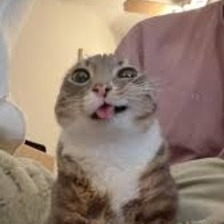

In [11]:
# loading image with PIL library
# img = Image.open(requests.get('https://github.com/yandexdataschool/Practical_DL/blob/fall24/week04_finetuning/sample_images/albatross.jpg?raw=true', stream=True).raw)
img = Image.open(os.path.join(os.getcwd(),'data','rigby.jpg'))  # alternative source
print(img.size)
img

In [12]:
# converting PIL image to torch.Tensor - detailed process
img_torch = torch.tensor(np.array(img), device=device)  # convert PIL image to np.array, then to torch.Tensor,
img_torch = img_torch.permute(2,0,1)  # reorder channels to move color to the front position, to match pytorch conventions
img_torch = img_torch / img_torch.max()  # scale to 0..1

img_torch.shape, img_torch.device, img_torch.min().item(), img_torch.max().item()  # verify shape, device and range

(torch.Size([3, 224, 224]), device(type='cuda', index=0), 0.0, 1.0)

In [13]:
# converting PIL image to torch.Tensor - easy process
# PIL image to torch.Tensor can be converted with torchvision.transforms, equivalent to the above code (more details below)
img_torch = transforms.ToTensor()(img)
img_torch.shape, img_torch.max(), img_torch.min()

(torch.Size([3, 224, 224]), tensor(1.), tensor(0.))

In [14]:
# Predicting image class with pretrained model


def predict_img(img, model, top_n=5):
    if isinstance(img, str):
        Image.open(requests.get(url, stream=True).raw).convert('RGB')  # for loading images from url

    img_torch = transforms.ToTensor()(img)  # to torch.Tensor, reorder color channels, s|cale to 0..1
    img_torch = transforms.Resize((224, 224))(img_torch)      # another useful transform to resize images
    img_torch = img_torch.unsqueeze(0)                        # add batch dimension (remember that model needs 4D input)
    img_torch = img_torch.to(device)                          # moving the tensor to device (presumably cuda, in initialized above)
    prediction = model(img_torch)                             # obtain prediction logits from the model
    probs = torch.nn.functional.softmax(prediction, dim=-1)   # convert logits into probabilities
    probs = probs.cpu().data.numpy()                          # convert CUDA tensor to numpy array

    top_ix = probs.ravel().argsort()[-1: -top_n - 1: -1]      # get indices of most probable classes
    print (f'top-{top_n} classes:')                           # look up class label
    for l in top_ix:
        print (f"{probs.ravel()[l]:>6.2%}  {imagenet_labels[l].split(',')[0]}")


predict_img(img, model)

top-5 classes:
20.01%  shower_curtain
17.83%  Persian_cat
 8.01%  plastic_bag
 5.11%  sleeping_bag
 4.52%  cradle


### testing the pretrained model 3: Images from unknown classes

Play with images from these and other (yours) URLS. Note how object outsize of imagenet classes confuse the net. Low probabilities in top classes are indications of model's low confidence.

In [65]:
for i, c in imagenet_labels.items():
    if c=="pizza":
        pizza_class=i
        print(i, " ", c)


963   pizza


In [66]:
url= 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSdDXn-0lG1ym-zHe1EDJ5LF4pecZO3-wcoug&s'                    # modern version

web_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')

In [67]:
img_torch = transforms.ToTensor()(web_img)
img_torch = transforms.Resize((224, 224))(img_torch)
img_torch = img_torch.unsqueeze(0)
img_torch = img_torch.to(device)
img_torch.requires_grad = True
img_opt = torch.optim.Adam([img_torch], lr=0.01)

In [68]:
img_torch.max()

tensor(0.9693, device='cuda:0', grad_fn=<MaxBackward1>)

In [69]:
for i in range(10):
    prediction = model(img_torch)
    logprobs = torch.log_softmax(prediction, dim=-1)
    logp_pizza = logprobs[0, pizza_class]

    img_opt.zero_grad()
    (-logp_pizza).backward()
    img_opt.step()
    with torch.no_grad():
        img_torch[...] = img_torch.clip(0, 1)

    print("P(pizza|x)", logp_pizza.exp().item())
    if logp_pizza.exp().item() > 0.5:
        break

P(pizza|x) 1.594905370438937e-05
P(pizza|x) 0.001559145632199943
P(pizza|x) 0.11994446814060211
P(pizza|x) 0.9005106687545776


top-5 classes:
96.84%  pizza
 0.35%  frying_pan
 0.27%  trifle
 0.18%  hamster
 0.16%  stingray


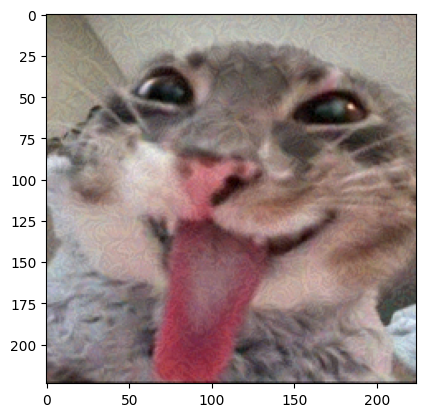

In [70]:
img_with_hack = img_torch[0].permute(1, 2, 0).cpu().data.numpy()
plt.imshow(img_with_hack)
predict_img(img_with_hack, model)

(204, 247)


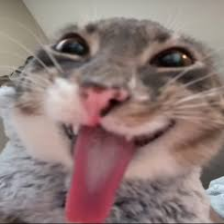

top-5 classes:
17.09%  Egyptian_cat
10.73%  shower_cap
 7.81%  tabby
 5.36%  tiger_cat
 4.10%  plastic_bag


In [71]:
url= 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSdDXn-0lG1ym-zHe1EDJ5LF4pecZO3-wcoug&s'                    # modern version

# <TRY ANY OTHER IMAGES YOU LIKE>

web_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')
print(web_img.size)
display(transforms.Resize((224, 224))(web_img))
predict_img(web_img, model)

## More Torchvision tools: Transforms and transform pipelines¶

You already used `transforms.ToTensor` and `transforms.Resize` above. There are many more at [Torchvision](https://pytorch.org/vision/stable/transforms.html). For easier application they are typically combined into pipelines. See examples below.

For more advanced tranforms (faster and compatible with tasks requiring mask or reference points), check out [Albumentations library](https://albumentations.ai/).

In [72]:
# Typical transform pipeline for test loop
transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Optional: normalize imaged according to ImageNet standards
])

# img = Image.open(requests.get('https://github.com/yandexdataschool/Practical_DL/blob/fall24/week04_finetuning/sample_images/albatross.jpg?raw=true', stream=True).raw)
img = Image.open(os.path.join(os.getcwd(),'data','rigby.jpg'))  # alternative source
img_torch = transform_pipeline(img)

print(type(img_torch), img_torch.shape)

<class 'torch.Tensor'> torch.Size([3, 224, 224])


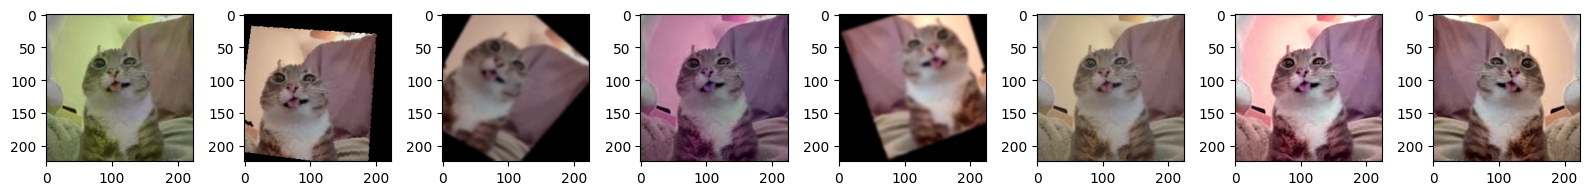

In [73]:
# img = Image.open(requests.get('https://github.com/yandexdataschool/Practical_DL/blob/fall24/week04_finetuning/sample_images/albatross.jpg?raw=true', stream=True).raw)
img = Image.open(os.path.join(os.getcwd(),'data','rigby.jpg'))  # alternative source
# img = Image.open('sample_images/albatross.jpg')  # alternative source

# Demo of augmentations for train pipeline

transform_pipeline_2 = transforms.Compose([
    transforms.RandomCrop((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomApply([
        transforms.RandomAffine(degrees=30, translate=(0.2, 0.2)),
        transforms.RandomRotation(30),
        transforms.GaussianBlur(kernel_size=25),
    ], p=0.5),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),  # not always applicable
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Optional: normalizes imaged according to ImageNet standards
])

fig, axs = plt.subplots(1, 8, figsize=(16, 4))
for i, ax in enumerate(axs.ravel()):
    img_2 = transform_pipeline_2(img)
    ax.imshow(img_2.permute(1, 2, 0))
plt.tight_layout()

# Classifying with CNN model's latent features
Pretrained image classification models learn extract image features that are useful in classification tasks. We need to get those features from outputs of the model's penultimate level and pass them to classifier.
While this is not exactly a proper finetuning, this method is quick, rather robust and allows to classify unknown classes using quite small training sets (tens / hundreds of images).

### How to get features
features = activations before the very last Linear layer of the model (named `fc` in Resnet - check the model structure above.

During good old days in Torch7 you could access any intermediate output from the sequential model. Nowadays it's a bit more difficult though it's not Tensorflow where you need to compile another model for that. Here we're going to redefine the last layer... yes, to do nothing.

In [74]:
# Create model clone with altered last layer
embedding_model = deepcopy(model)  # start with a clone of the original model
embedding_model.fc = torch.nn.Identity() # instead of classifier head - do nothing
embedding_model = embedding_model.to(device)  # move to CUDA if available

In [75]:
# img = Image.open(requests.get('https://github.com/yandexdataschool/Practical_DL/blob/fall24/week04_finetuning/sample_images/albatross.jpg?raw=true', stream=True).raw)
img = Image.open(os.path.join(os.getcwd(),'data','rigby.jpg'))  # alternative source
img_torch = transforms.ToTensor()(img).unsqueeze(0).to(device)
out = embedding_model(img_torch).cpu().data.numpy()
assert out.shape == (1, 512), "your output for single image should have shape (1, 512)"

# Starter problem: cat-dog classification
Your next task is to use a pre-trained model to distinguish between cats and dogs.
- viewed as imposible in 2000
- popular data science challenge problem in 2010
- warm-up task for students in 2020s <br>
![cat_meme](https://i.imgur.com/u1bubWv.jpeg)

In [77]:
# download the dataset
!wget https://storage.yandexcloud.net/yandex-research/courses/dogs_vs_cats_1000.zip -O data.zip -q --show-progress

data.zip            100%[===================>]  44.25M  10.2MB/s    in 4.3s    


In [79]:
!unzip -qn data.zip
!ls data/dogs_vs_cats_1000 | wc -l  # should be 2000 images extracted

2000


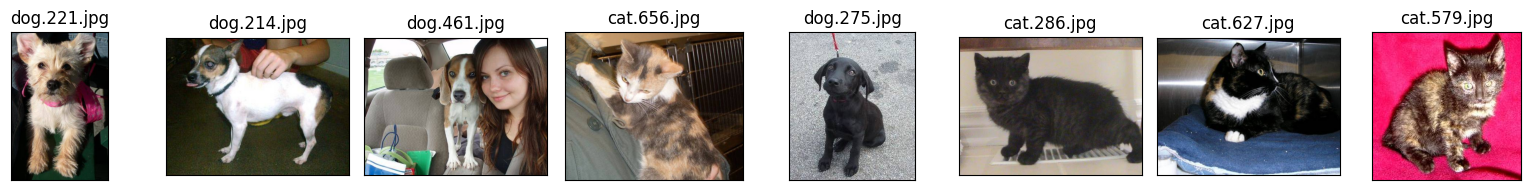

In [82]:
# Sample pets images
import random
fig, axs = plt.subplots(1, 8, figsize=(16, 2))

dataset_path = os.path.join("data", "dogs_vs_cats_1000")

fnames = [fn for fn in os.listdir(dataset_path)]
for ax, fname in zip(axs.ravel(), random.choices(fnames, k=8)):
    img_ = Image.open(os.path.join(dataset_path, fname))
    ax.imshow(img_)
    ax.set_title(f"{fname}")
    ax.tick_params(left = False,labelleft = False , labelbottom = False, bottom = False)
plt.tight_layout()

In [88]:
# Here we generate image embeddings using the activations before the last layer
# use batches to accelerate the process

X_ = []  # storage for batches embeddings
Y_ = []  # storage for batches labels

filenames = [fname for fname in os.listdir(dataset_path) if os.path.isfile(os.path.join(dataset_path, fname))]
batch_size = 64
x_batch_list = []  # to accumulate batch components

with torch.no_grad():
    for i, fname in enumerate(tqdm(filenames)):
        img = Image.open(os.path.join(dataset_path, fname))
        img_torch = transforms.ToTensor()(img.resize((224, 224)))
        x_batch_list.append(img_torch)
        Y_.append(1 if fname.startswith("cat") else 0)

        if len(x_batch_list) == batch_size or i >= len(filenames) - 1:
            x_batch = torch.stack(x_batch_list) # [64, 3, H, W]
            # use your embedding model to produce embeddings vectors, save results on CPU
            embeddings = embedding_model(x_batch.to(device)).cpu()

            assert isinstance(embeddings,  torch.Tensor) and embeddings.device.type == "cpu"
            assert embeddings.ndim == 2 and embeddings.shape[1] == 512
            X_.append(embeddings)
            x_batch_list = []

  0%|          | 0/2000 [00:00<?, ?it/s]

In [89]:
X = np.concatenate(X_, axis = 0)  # concatenate all batches' embeddings into single 2D array.
Y = np.array(Y_[:len(X)])  # convert labels into np array; crop if we ended prematurely

print(X.shape, Y.shape, np.mean(Y))

assert X.ndim == 2 and X.shape[1] == 512
assert X.shape[0] == len(filenames)
assert Y.ndim == 1 and Y.shape[0] == X.shape[0]
assert 0.49 <= np.mean(Y) <= 0.51

(2000, 512) (2000,) 0.5
